# [OGprimer chapter 2](https://github.com/OpenRG/OGprimer/blob/master/Chapters/OGtext_ch02.pdf) exercises

## 2.6 Calibration

Use the following parameterization of the model for the problems below. Because agents live
for only three periods, assume that each period of life is 20 years. If the annual discount
factor is estimated to be 0.96, then the 20-year discount factor is β = 0.9620 = 0.442.
Let the annual depreciation rate of capital be 0.05. Then the 20-year depreciation rate is
δ = 1 − (1 − 0.05)20 = 0.6415. Let the coefficient of relative risk aversion be σ = 3, let
the productivity scale parameter of firms be A = 1, and let the capital share of income be
α = 0.35.

In [127]:
# "Because agents live for only three periods, assume that each period of life
#  is 20 years."
PERIOD_YEARS = 20
# If the annual discount factor is estimated to be 0.96...
ANNUAL_DISCOUNT = 0.96
# ...then the 20-year discount factor is 0.96^20 = 0.442.
BETA = 0.442
# Let the annual depreciation rate of capital be 0.05.
ANNUAL_DEPR = 0.05
# Then the 20-year depreciation rate is 1 - (1 - 0.05)^20 = 0.6415.
DELTA = 0.6415
# Let the coefficient of relative risk aversion be 3,
CRRA = 3
# let the productivityscale parameter of firms be A = 1,
A = 1
# and let the capital share of income be 0.35.
ALPHA = 0.35
# Assuming the same labor vector as section 2.1.
NVEC = [1, 1, 0.2]
n = sum(NVEC)
L = n

## Exercise 2.1
Using the calibration from Section 2.6, write a Python function named `feasible()` that has the following form,
```
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
```
where the inputs are a tuple `f_params = (nvec, A, alpha, delta)`, and a guess for the steady-state savings vector `bvec_guess = np.array([scalar, scalar])`.
The outputs should be Boolean (`True` or `False`, `1` or `0`)
vectors of lengths 2, 3, and 1, respectively.
`K_cnstr` should be a singleton Boolean that equals `True` if $K \leq 0$ for the given `f_params` and `bvec_guess`.

The object `c_cnstr` should be a length-3 Boolean vector in which the $s$th element equals `True` if $c_s \leq 0$
given `f_params` and `bvec_guess`.
And `b_cnstr` is a length-2 Boolean vector that denotes which element of `bvec_guess` is likely responsible for any of the consumption nonnegativity constraint violations identified in `c_cnstr`.
If the first element of `c_cnstr` is `True`, then the first element of `b_cnstr` is `True`.
If the second element of `c_cnstr` is `True`, then both elements of `b_cnstr` are `True`.
And if the last element of `c_cnstr` is `True`, then the last element of `b_cnstr` is `True`.

*Comment: Shrinking 3-element `c_cnstr` down to 2-element `b_cnstr` was confusing. Is this extra parsimony necessary?*

*Question: Should it be $c_s \leq 0$ or $c_s < 0$?*

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import time

In [129]:
def u_crra(c, crra=CRRA):
    return (c ** (1 - crra) - 1) / (1 - crra)

# Derivative of CRRA is c^(-sigma)
def du_crra(c, crra=CRRA):
    return c ** (-crra)

In [130]:
def w_t(b_2_t, b_3_t, alpha=ALPHA, A=A, n=n):
    """ Equilibrium wage rate as a function of the distribution of capital,
        capital income share, productivity, and total labor.
    
    Args:
        b_2_t: Savings at age 2 as of time t.
        b_3_t: Savings at age 3 as of time t.
        alpha: Capital income share.
        A: Productivity.
        n: Total labor. 

    Returns:
        Equilibrium wage rate as of time t.
    """
    return (1 - alpha) * A * ((b_2_t + b_3_t) / n) ** alpha

In [131]:
def wpath(Kpath, alpha=ALPHA, A=A, n=n):
    """ Wage path given aggregate capital path.
    """
    return np.power((1 - alpha) * A * Kpath / n, alpha)

In [132]:
def r_t(b_2_t, b_3_t, alpha=ALPHA, A=A, n=n, delta=DELTA):
    """ Equilibrium interest rate as a function of the distribution of capital,
        capital income share, productivity, total labor, and depreciation rate.
    
    Args:
        b_2_t: Savings at age 2 as of time t.
        b_3_t: Savings at age 3 as of time t.
        alpha: Capital income share.
        A: Productivity.
        n: Total labor.
        delta: Depreciation rate.

    Returns:
        Equilibrium interest rate as of time t.
    """
    return alpha * A * (n / (b_2_t + b_3_t)) ** (1 - alpha) - delta

In [133]:
def rpath(Kpath, alpha=ALPHA, A=A, n=n, delta=DELTA):
    """ Interest rate path given aggregate capital path.
    """
    return alpha * A * np.power(n / Kpath, 1 - alpha) - delta

In [134]:
def c(b_2, b_3, w, r, nvec):
    c_1 = nvec[0] * w - b_2
    c_2 = nvec[1] * w + (1 + r) * b_2 - b_3
    c_3 = nvec[2] * w + (1 + r) * b_3
    return c_1, c_2, c_3

In [135]:
def feasible(f_params, bvec_guess):
    """ Identifies whether constraints can be satisfied given economic
        parameters and an initial guess of steady-state savings.

    Args:
        f_params: Tuple (nvec, A, alpha, delta).
        bvec_guess: np.array([scalar, scalar]).
    
    Returns:
        Tuple of Boolean vectors:
        - b_cnstr (length 2, denotes which element of bvec_guess is likely
                   responsible for consumption nonnegativity constraint
                   violations identified in c_cnstr)
        - c_cnstr (length 3, true if c_s <= 0)
        - K_cnstr (length 1, true if K <= 0)
    """
    # Extract params.
    nvec, A, alpha, delta = f_params
    b_2, b_3 = bvec_guess
    # Calculate total labor supply.
    n = sum(nvec)
    # Calculate equilibrium wage and interest rates.
    w = w_t(b_2, b_3, alpha, A, n)
    r = r_t(b_2, b_3, alpha, A, n, delta)
    # Calculate consumption levels via Equation 2.7.
    c_1, c_2, c_3 = c(b_2, b_3, w, r, nvec)
    # Calculate K via market-clearing condition, Equation 2.23.
    K = b_2 + b_3
    # Define constraints violations.
    c_cnstr = [c_1 < 0, c_2 < 0, c_3 < 0]
    K_cnstr = K < 0
    # Identify the element of bvec_guess likely responsible.
    b_cnstr = [False, False]
    if c_1 < 0:
        b_cnstr[0] = True
    if c_2 < 0:
        b_cnstr = [True, True]
    if c_3 < 0:
        b_cnstr[1] = False
    # Return
    return b_cnstr, c_cnstr, K_cnstr

In [136]:
def infeasible(f_params, bvec_guess):
    """ Simple True/False indicating whether it's infeasible.
    """
    b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
    return any([any(b_cnstr), any(c_cnstr), K_cnstr])

## 2.1a

Which, if any, of the constraints is violated if you choose an initial guess for steady-state savings of `bvec_guess = np.array([1.0, 1.2])`?

In [137]:
F_PARAMS = (NVEC, A, ALPHA, DELTA)

In [138]:
feasible(F_PARAMS, np.array([1.0, 1.2]))

([True, False], [True, False, False], False)

In [139]:
infeasible(F_PARAMS, np.array([1.0, 1.2]))

True

### 2.1b

In [140]:
feasible(F_PARAMS, np.array([0.06, -0.001]))

([False, False], [False, False, False], False)

In [141]:
infeasible(F_PARAMS, np.array([0.06, -0.001]))

False

### 2.1c

In [142]:
feasible(F_PARAMS, np.array([0.1, 0.1]))

([False, False], [False, False, False], False)

In [143]:
infeasible(F_PARAMS, np.array([0.1, 0.1]))

False

## 2.2

Use the calibration function from Section 2.6 and the steady-state equilibrium Definition 2.1.
Write a function named `get_SS()` that has the following form,
```
ss_output = get_SS(params, bvec_guess, SS_graphs)
```
where the inputs are a tuple of the parameters for the model
`params = ((beta, sigma, nvec, L, A, alpha, delta, SS_tol))`,
and initial guess of the steady-state savings `bvec_guess`,
and a Boolean `SS_graphs` that generates a figure of the
steady-state distribution of consumption and savings
if it is set to `True`.
The output object `ss_output` is a Python dictionary
with the steady-state solution values for the following
endogenous objects.
```
ss_output - {
    'b_ss': b_ss,
    'c_ss': c_ss,
    'w_ss': w_ss,
    'r_ss': r_ss,
    'K_ss': K_ss,
    'Y_ss': Y_ss,
    'C_ss': C_ss,
    'EulErr_ss': EulErr_ss,
    'RCerr_ss': RCerr_ss,
    'ss_time': ss_time
}
```
Let `ss_time` be the number of seconds it takes to run your steady-stateprogram.
You can time your program by importing the `time` library.
```
import time
...
start_time = time.clock()  # Place at beginning of get_SS()
...
ss_time = time.clock() - start_time  # Place at end of get_SS()
```
And let the object EulErr_ss be a length-2 vector of the
two Euler errors from the resulting steady-state
solution given in difference form
$\beta (1 + \bar{r})u'(\bar{c}_{s+1}) -u'(\bar{c}_s)$.
The object `RCerr_ss` is a resource constraint error which should be close to zero.
It is given by $\bar{Y} - \bar{C} - \delta \bar{K}$.

In [144]:
r_t(0.1, .5)

0.1729125812512312

In [145]:
def ss_opt_fun(bvec, beta, sigma, nvec, L, A, alpha, delta):
    """ Function to root-find to get steady-state solution.

    Args:
        bvec: Vector of steady-state savings [b2, b3].
        params: Tuple of (beta, sigma, nvec, L, A, alpha, delta).

    Returns:
        Vector of Euler errors.
    """
    # (nvec, A, alpha, delta
    if infeasible((nvec, A, alpha, delta), bvec):
        return [100, 100]
    b_2, b_3 = bvec
    n_1, n_2, n_3 = nvec
    # Start with LHS and RHS of equations 2.29 and 2.30.
    # Replace 1/1/0.2 with n1/n2/n3.
    # 2.29: u'(n_1*w(b_2,b_3)-b_2) =
    #       beta*(1+r(b_2,b_3))u'(n_2*w(b_2,b_3)+[1+r(b_2,b_3)]b_2-b_3)
    # 2.30: u'(n_2*w(b_2,b_3)+[1+r(b_2,b_3)]b_2-b_3)=
    #       B(1+r(b_2,b_3))u'([1+r(b_2,b_3)]b_3+n_3*w(b_2,b_3))
    # u' function: du_crra(c, crra=CRRA)
    # w function: w_t(b_2_t, b_3_t, alpha=ALPHA, A=A, n=n)
    # r function: r_t(b_2_t, b_3_t, alpha=ALPHA, A=A, n=n, delta=DELTA)
    w = w_t(b_2, b_3, alpha, A, n)
    r = r_t(b_2, b_3, alpha, A, n, delta)
    lhs_2_29 = du_crra(n_1 * w - b_2, sigma)
    rhs_2_29 = beta * (1 + r) * du_crra(n_2 * w + (1 + r) * b_2 - b_3)
    lhs_2_30 = du_crra(n_2 * w + (1 + r) * b_2 - b_3, sigma)
    rhs_2_30 = beta * (1 + r) * du_crra((1 + r) * b_3 + n_3 * w)
    return [lhs_2_29 - rhs_2_29, lhs_2_30 - rhs_2_30]

In [146]:
def get_SS(params, bvec_guess, SS_graphs=False):
    """ Calculates steady-state solution.

    Args:
        params: Tuple of (beta, sigma, nvec, L, A, alpha, delta, SS_tol).
        bvec_guess: Initial guess of steady-state savings.
        SS_graphs: Boolean that generates a figure of the steady-state
            distribution of consumption and savings if set to True.
            Defaults to False.
    
    Returns:
        Dictionary with the steady-state solution values for the
        following endogenous objects:
        b_ss: Length-2 vector of steady-state savings b_2_ss and b_3_ss.
        c_ss: Length-3 vector of steady-state consumption.
        w_ss: Steady-state wage.
        r_ss: Steady-state interest rate.
        K_ss: Steady-state capital.
        Y_ss: Steady-state income.
        C_ss: Steady-state consumption  (how does this differ from c_ss?).
        EulErr_ss: Length-2 vector of the two Euler errors from the resulting
            steady-state solution given in difference form
            beta(1+r)u'(c_{s+1}) - u'(c_s).
        RCerr_ss: Resource constraint error which should be close to zero.
            It is given by Y-C-delta*K.
        ss_time: Run time in seconds.
    """
    # Extract parameters.
    start_time = time.clock()
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    # Solve.
    opt_res = opt.root(ss_opt_fun, bvec_guess, params[:-1], tol=SS_tol)
    # Extract features from the optimization result.
    b2_ss, b3_ss = b_ss = opt_res.x
    EulErr_ss = opt_res.fun
    # Calculate other quantities.
    w_ss = w_t(b2_ss, b3_ss, alpha, A, L)
    r_ss = r_t(b2_ss, b3_ss, alpha, A, L, delta)
    c_ss = c(b2_ss, b3_ss, w_ss, r_ss, nvec)
    K_ss = sum(b_ss)
    C_ss = sum(c_ss)
    # Calculate output via production function, not market-clearing.
    Y_ss = A * (K_ss ** alpha) * (L ** (1 - alpha))
    RCerr_ss = Y_ss - C_ss - delta * K_ss
    ss_time = time.clock() - start_time
    if SS_graphs:
        pd.Series(c_ss).plot.bar()
        plt.title('Consumption')
        plt.show()
        pd.Series(b_ss).plot.bar()
        plt.title('Savings')
        plt.show()
    return {'b_ss': b_ss,
            'c_ss': c_ss,
            'w_ss': w_ss,
            'r_ss': r_ss,
            'K_ss': K_ss,
            'Y_ss': Y_ss,
            'C_ss': C_ss,
            'EulErr_ss': EulErr_ss,
            'RCerr_ss': RCerr_ss,
            'ss_time': ss_time
            }

### 2.2a

Solve numerically for the steady-state equilibrium values of ${\bar{c}_s}_{s=1}^3, {\bar{b}_s}_{s=2}^3, \bar{w}, \bar{r}, \bar{K}, \bar{Y}, \bar{C},$
the two Euler errors and the resource constraint error.
List those values.
Time your function.
How long did it take to compute the steady-state?

In [147]:
SIGMA = 3  # What is this supposed to be?
PARAMS = BETA, SIGMA, NVEC, L, A, ALPHA, DELTA
SS_TOL = 1e-10

In [148]:
get_SS(PARAMS + (SS_TOL,), [0.1, 0.1], False)

{'C_ss': 0.6329006729395864,
 'EulErr_ss': array([-1.39266376e-12,  2.62900812e-12]),
 'K_ss': 0.07772362575316386,
 'RCerr_ss': 8.326672684688674e-17,
 'Y_ss': 0.6827603788602411,
 'b_ss': array([0.01931253, 0.0584111 ]),
 'c_ss': (0.18241212755849867, 0.20961468030898922, 0.24087386507209851),
 'r_ss': 2.433062339127069,
 'ss_time': 0.0012659999999993232,
 'w_ss': 0.20172465739052575}

### 2.2b

Generate a figure that shows the steady-state distribution of consumption and savings by age ${\bar{c}_s}_{s=1}^3$ and ${\bar{b}_s}_{s=2}^3$.

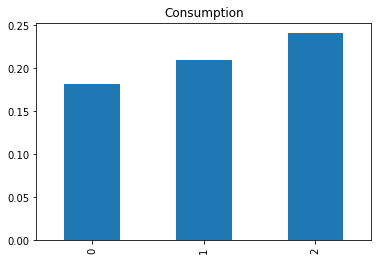

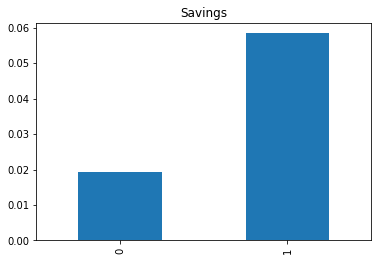

{'C_ss': 0.6329006729395864,
 'EulErr_ss': array([-1.39266376e-12,  2.62900812e-12]),
 'K_ss': 0.07772362575316386,
 'RCerr_ss': 8.326672684688674e-17,
 'Y_ss': 0.6827603788602411,
 'b_ss': array([0.01931253, 0.0584111 ]),
 'c_ss': (0.18241212755849867, 0.20961468030898922, 0.24087386507209851),
 'r_ss': 2.433062339127069,
 'ss_time': 0.0009220000000009776,
 'w_ss': 0.20172465739052575}

In [149]:
get_SS(PARAMS + (SS_TOL,), [0.1, 0.1], True)

### 2.2c

What happens to each of these steady-state values if all households become more patient
$\beta \uparrow$
(an example would be $\beta = 0.55$)?
That is, in what direction does $\beta \uparrow$
move each steady-state value? What is the intuition?

*Capital, consumption, and wages rise; interest rate falls.*

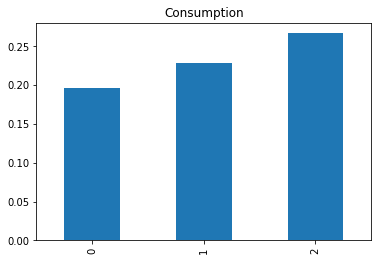

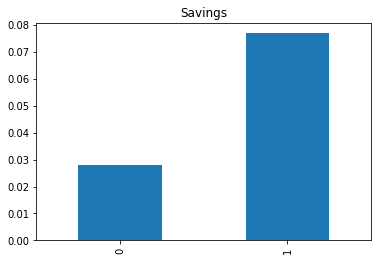

{'C_ss': 0.6912842903551415,
 'EulErr_ss': array([ 5.68434189e-14, -2.84217094e-14]),
 'K_ss': 0.10504237022597478,
 'RCerr_ss': 1.3877787807814457e-17,
 'Y_ss': 0.7586689708551043,
 'b_ss': array([0.02817692, 0.07686545]),
 'c_ss': (0.19597527701928266, 0.22861594138399466, 0.2666930719518642),
 'r_ss': 1.8863765057190747,
 'ss_time': 0.0007549999999998391,
 'w_ss': 0.22415219593446262}

In [150]:
BETA = 0.55
PARAMS = BETA, SIGMA, NVEC, L, A, ALPHA, DELTA
get_SS(PARAMS + (SS_TOL,), [0.1, 0.1], True)

## 2.3

Use time path iteration (TPI) to solve for the non-steady state equilibrium transition path of the economy from $(b_{2,1},b_{3,1})=(0.8 \bar{b}_2, 1.1\bar{b}_3)$ to the steady-state $(\bar{b}_2, \bar{b}_3)$.
You'll have to choose a guess for $T$ and a time path updating parameter $\xi \in (0,1)$,
but I can assure you that $T<50$.
Use an $L^2$ norm for your distance measure
(sum of squared percent deviations),
and use a convergence parameter of $\epsilon=10^{-9}$.
Use a linear initial guess for the time path of the
aggregate capital stock from the initial state
$K_1^1$ to the steady state $K_T^1$ at time $T$.

In [151]:
def b_3_2_opt_fun(b_3_2, bvec, Kpath, beta, sigma, nvec, L, A, alpha, delta):
    """ Function to root-find to get steady-state solution.

    Args:
        b_3_2: Savings of middle-aged s=2 for the last period of his life.
        bvec: Initial savings [b_2_1, b_3_1].
        Kpath: Transition path of aggregate capital.
        beta:
        sigma:
        nvec:
        L:
        A:
        alpha:
        delta:

    Returns:
        Euler error.
    """
    # # (nvec, A, alpha, delta
    # if infeasible((nvec, A, alpha, delta), bvec):
    #     return [100, 100]
    b_2_1, b_3_1 = bvec
    n_1, n_2, n_3 = nvec
    w = wpath(Kpath, alpha, A, n)
    r = rpath(Kpath, alpha, A, n, delta)
    lhs = du_crra(n_2 * w[0] + (1 + r[0]) * b_2_1 - b_3_2, sigma)
    rhs = beta * (1 + r[1]) * du_crra((1 + r[2] * b_3_2 + n_2 * w[1]), sigma)
    return [lhs - rhs]

In [153]:
PARAMS

(0.55, 3, [1, 1, 0.2], 2.2, 1, 0.35, 0.6415)

In [ ]:
opt.root(b_3_2_opt_fun, 0.1, [bvec, Kpath, beta, sigma, nvec, L, A, alpha, delta], tol=SS_tol)

In [155]:
# Solve b_{3,2} via equation 2.31.
def tpi_b_3_2(b_3_2_guess, bvec, Kpath, beta, sigma, nvec, L, A, alpha, delta,
              tol):
    return opt.root(b_3_2_opt_fun, b_3_2_guess,
                    (bvec, Kpath, beta, sigma, nvec, L, A, alpha, delta),
                    tol=tol)

In [ ]:
tpi_b_3_2(0.1, )

In [ ]:
# Solve b_{2,2} and b{3,3} for initial young s=1 agent at period 1 using
# equations 2.32 and 2.33.
def tpi_b_2_2_b_3_3(n_1, w_1, beta, r_2, n_2, w_2, r_3, n_3, w_3):
    b_2_2, b_3_3 = 0, 0  # Initialize before optimizing.
    lhs_2_32 = du_crra(n_1 * w_1 - b_2_2)
    rhs_2_32